In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import chi2
from sklearn import datasets
from sklearn.metrics import confusion_matrix

In [127]:
iris = datasets.load_iris()

In [128]:
df = pd.DataFrame(iris.data)
df.columns = ['col_1', 'col_2', 'col_3', 'col_4']
df.head()

,col_1,col_2,col_3,col_4
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
df.shape

(150, 4)

## For no Change

#### Creating W1 and W2 disjoint sets

In [5]:
W1 = df.sample(50)

In [6]:
W2 = df.drop(W1.index , axis = 0).sample(50)

In [7]:
W1.reset_index(drop = True, inplace = True)
W2.reset_index(drop = True, inplace = True)

In [8]:
W1 = W1.to_numpy()
W2 = W2.to_numpy()

In [9]:
kmeans = KMeans(n_clusters = 3).fit(W1)

In [10]:
labels = kmeans.predict(W1)

In [11]:
W1[labels == 1].shape[0]

15

In [12]:
kmeans.cluster_centers_

array([[6.67857143, 2.98571429, 5.52142857, 1.99285714],
       [5.07333333, 3.36666667, 1.48      , 0.27333333],
       [5.85714286, 2.71904762, 4.37619048, 1.38571429]])

In [13]:
labels

array([1, 0, 2, 1, 0, 2, 2, 0, 1, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 0, 1, 1,
       2, 1, 2, 1, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 1, 1, 0, 0, 0,
       1, 2, 0, 1, 2, 0], dtype=int32)

In [14]:
np.nonzero(labels == 1)[0]

array([ 0,  3,  8, 11, 14, 20, 21, 23, 25, 27, 31, 39, 40, 44, 47])

In [15]:
np.cov(W1[labels==1].T)

array([[ 0.0492381 ,  0.03690476, -0.00485714,  0.00709524],
       [ 0.03690476,  0.06952381,  0.01071429,  0.01761905],
       [-0.00485714,  0.01071429,  0.03028571,  0.00585714],
       [ 0.00709524,  0.01761905,  0.00585714,  0.01638095]])

In [16]:
W1[labels == 1].shape

(15, 4)

In [17]:
c = np.array([5,15,10,20])
c = c / 50

In [18]:
sc = np.zeros((5*5,4))

In [19]:
sc = np.random.rand(25,4)

In [20]:
np.tile(c, (25,1)).T.shape

(4, 25)

In [21]:
sc.shape

(25, 4)

In [22]:
np.sum(sc*(np.tile(c, (25,1))),1)

array([0.28611427, 0.44163482, 0.83077519, 0.54157962, 0.62608178,
       0.62759913, 0.82219584, 0.54937484, 0.27319453, 0.2276199 ,
       0.37998607, 0.53903663, 0.83049526, 0.29717607, 0.61683831,
       0.78503962, 0.66749441, 0.2289121 , 0.5958202 , 0.72074868,
       0.58667682, 0.36365543, 0.47716338, 0.42903341, 0.62993615])

In [23]:
def mahalanobis(W1, W2, K):
    """
    W1 = data from window 1
    W2 = data from window 2
    K = number of clusters.
    """
    
    # m1 - number of rows sampled
    # n - number of features (should be same for W1 and W2)
    m1, n = W1.shape
    m2 = W2.shape[0]
    
    # Using K-means for clustering since Gaussian will be computationally very expensive
    kmeans = KMeans(n_clusters = K).fit(W1)
    
    # means of each cluster to calculate the probability function of each cluster
    labels = kmeans.predict(W1)
    means = kmeans.cluster_centers_
    
    # Common covariance matrix initialisation for each cluster
    cov_store = np.zeros((n*n,K))
    weights = np.zeros((K))
    
    # weight calculation for each cluster
    for i in range(K):
        w = W1[labels == i].shape[0]
        weights[i] = w
        if (w > 1):
            co = np.cov(W1[labels == i].T)
            cov_store[:,i] = co.flatten()
    
    weights /= m1
    
    sc = np.sum(cov_store*(np.tile(weights, (n*n,1))),1)
    
    # Inverse of covariance calculation for mahalanobis distance
    sc = np.reshape(sc, (n,n))
    invcov = np.linalg.pinv(sc)
    
    covsum = np.zeros((m2))
    
    # Calculate the Mahalanobis distance
    for i in range(m2):        
        dist = np.zeros((K))
        for k in range(K):
            if weights[k] > 0:
                dist[k] = np.dot(np.dot(means[k,:] - W2[i,:] , invcov), means[k,:] - W2[i,:])
            else:
                dist[k] = np.inf
        covsum[i] = np.min(dist)
    
    # Return the mean of variance of each cluster
    return np.mean(covsum)

In [24]:
mahalanobis(W1,W2,3)

4.031402940934819

In [25]:
p = 0.7
float(p < 0.5)

0.0

In [26]:
1-chi2.cdf(4.16,3)

0.24469728058103823

In [116]:
def SPLL(W1,W2,K):
    
    n = W1.shape[1]
    
    s1 = mahalanobis(W1,W2,K)
    s2 = mahalanobis(W1, W2, K)
    
    s = max(s1,s2)
    # Chi square value for n degree of freedoms
    p_val = chi2.cdf(s,n)
    # Two-tailed chi square test
    ps = min (p_val, 1 - p_val)
    
    # Considering the confidence interval to be 0.05
    return ps, s
    

In [70]:
SPLL(W1,W2,3,0.05)

(1, 0.0, 662.693093525989)

In [29]:
W2[:,[0,3]] = W2[:,[3,0]]

In [71]:
SPLL(W1,W2,3,0.05)

(1, 0.0, 665.7922881915224)

In [31]:
def create_samples(df, elements):
    W1 = df.sample(elements)
    W2 = df.drop(W1.index , axis = 0).sample(50)
    
    W1.reset_index(drop = True, inplace = True)
    W2.reset_index(drop = True, inplace = True)
    
    W1 = W1.to_numpy()
    W2 = W2.to_numpy()
    return W1,W2

In [32]:
def swap_columns(arr):
    n = arr.shape[1]
    r = np.random.randint(n, size = (1,2))
    while (r[0,0] == r[0,1]):
        r = np.random.randint(n, size = (1,2))
    
    arr[:, [r[0,0],r[0,1]]] = arr[:, [r[0,1],r[0,0]]]
    
    return arr
        

In [98]:
def no_change_cal(df,count = 50):
#     A_nochange = [0 for i in range(count)]
#     p_val = [0 for i in range(count)]
#     m_dist = [0 for i in range(count)]
    W1 = [0 for i in range(count)]
    W2 = [0 for i in range(count)]
    for i in range(count):
        W1[i],W2[i] = create_samples(df,count)
#         A_nochange[i],p_val[i],m_dist[i] = SPLL(W1,W2,K,alpha)
#     print (A_change[-1])
#     return A_nochange,p_val,m_dist
    return W1,W2

In [96]:
np.zeros([1,10,3])

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [97]:
def change_cal(df,count = 50):
#     A_change = [0 for i in range(count)]
#     p_val = [0 for i in range(count)]
#     m_dist = [0 for i in range(count)]
    W1 = [0 for i in range(count)]
    W2 = [0 for i in range(count)]
    for i in range(count):
        W1[i],W2[i] = create_samples(df,count)
        W2[i] = swap_columns(W2[i])
#         A_change[i],p_val[i],m_dist[i] = SPLL(W1,W2,K,alpha)
#     print (A_change[-1])
#     return A_change,p_val,m_dist
    return W1,W2

In [136]:
data_count = 80
count = 50
num = 100
K = 3

tpr = [0 for i in range(num)]
fpr = [0 for i in range(num)]
#     A_nochange,_,_ = no_change_cal(df,2,alpha,50)
#     A_change,_,_ = change_cal(df,2,alpha,50)

w11,w12 = no_change_cal(df,data_count)
w21,w22 = change_cal(df,data_count)
ps_nochange = [0 for i in range(count)]
ps_change = [0 for i in range(count)]
s_nochange = [0 for i in range(count)]
s_change = [0 for i in range(count)]
for i in range(count):
    ps_nochange[i],s_nochange[i] = SPLL(w11[i],w12[i],3)
    ps_change[i],s_change[i] = SPLL(w21[i],w22[i],3)

    
for k,alpha in enumerate(np.linspace(0,0.6,num)):
    A_nochange = [0 for i in range(count)]
    A_change = [0 for i in range(count)]
    for i in range(count):
        A_nochange[i] = float(ps_nochange[i] < alpha)
        A_change[i] = float(ps_change[i] < alpha)
    A_criterion = A_nochange + A_change
    actual = [0 for i in range(count)] + [1 for i in range(count)]
    tn, fp, fn, tp = confusion_matrix(actual,A_criterion).ravel()
    tpr[k] = tp/(tp+fn)
    fpr[k] = fp/(fp+tn)
#     print (A_criterion,'\n',actual)
    #print (confusion_matrix(actual,A_criterion), tpr[k],fpr[k],'tp:',tp,'tn:',tn,'fp:',fp,'fn:',fn)

In [137]:
len(w11)

80

In [143]:
df.index

RangeIndex(start=0, stop=14500, step=1)

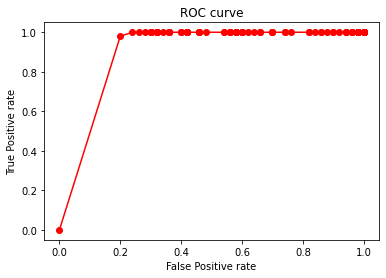

In [142]:
plt.plot(fpr,tpr,'-ro')
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC curve")
plt.show()

In [99]:
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve

In [100]:
roc_curve([1,0,1,0],[1,1,1,0])

(array([0. , 0.5, 1. ]), array([0., 1., 1.]), array([2, 1, 0]))

In [101]:
confusion_matrix([1,0,1,0],[1,1,1,0]).ravel()

array([1, 1, 0, 2])

In [102]:
confusion_matrix([1,0,1,0],[1,1,1,0])

array([[1, 1],
       [0, 2]])

In [104]:
for i,j in enumerate([3,4,5]):
    print(i,j)

0 3
1 4
2 5


## Satimage dataset

In [131]:
df = pd.read_csv('satimage_csv.csv')
df.head()

,Aattr,Battr,Cattr,Dattr,Eattr,Fattr,A1attr,B2attr,C3attr,D4attr,...,D22attr,E23attr,F24attr,A25attr,B26attr,C27attr,D28attr,E29attr,F30attr,class
0,0.117596,1.241362,1.184036,0.815302,-0.158561,1.256483,1.193546,0.818486,-0.141965,0.879481,...,0.807707,-0.069968,1.219160,1.250463,0.597678,-0.054291,1.233342,1.262255,0.603258,1
1,-1.205362,-1.249654,-0.077532,0.444886,-0.895959,-0.447579,-0.786760,-0.554203,-0.364672,0.092157,...,-0.192752,-0.736996,-0.969292,-0.844805,-0.400030,-0.725852,-0.344432,-0.594534,-0.183967,5
2,0.779075,0.148811,0.042617,-0.243030,0.800057,0.164136,0.053370,-0.448612,0.154978,-0.345245,...,-0.877277,0.671174,-0.006373,-0.425752,-0.662584,0.691889,0.356801,-0.175259,-0.236449,7
3,1.146564,0.585831,0.342991,0.021553,0.947536,0.601074,0.353416,0.026550,1.788164,1.010702,...,0.281150,1.412317,1.044084,0.532085,0.282612,1.438068,1.058033,0.842981,0.130923,3
4,-0.764376,-1.162250,-0.137607,0.180303,-0.969698,-1.146681,-0.126658,0.184937,-0.735851,-1.132569,...,-0.192752,-0.885225,-1.231906,-0.784941,-0.347519,-0.875088,-1.220973,-0.774223,-0.551339,5


In [40]:
tpr = [0 for i in range(20)]
fpr = [0 for i in range(20)]
for i,alpha in enumerate(np.linspace(0,1,20)):
    A_nochange,_,_ = no_change_cal(df,3,alpha,50)
    A_change,_,_ = change_cal(df,3,alpha,50)
    A_criterion = A_nochange + A_change
    actual = [0 for i in range(50)] + [1 for i in range(50)]
    tn, fp, fn, tp = confusion_matrix(actual,A_criterion).ravel()
    tpr[i] = tp/(tp+fn)
    fpr[i] = fp/(fp+tn)

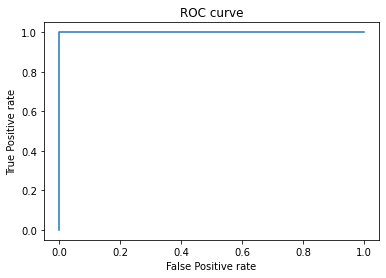

In [41]:
plt.plot(fpr,tpr)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC curve")
plt.show()

## Shuttle dataset

In [135]:
df = pd.read_csv('shuttle.csv', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,55,0,81,0,-6,11,25,88,64,4
1,56,0,96,0,52,-4,40,44,4,4
2,50,-1,89,-7,50,0,39,40,2,1
3,53,9,79,0,42,-2,25,37,12,4
4,55,2,82,0,54,-6,26,28,2,1


In [42]:
iter = [0 for i in range(100)]
tpr = [0 for i in range(100)]
fpr = [0 for i in range(100)]
for i,alpha in enumerate(np.linspace(0,1,20)):
    A_nochange,_,_ = no_change_cal(df,3,alpha,50)
    A_change,_,_ = change_cal(df,3,alpha,50)
    A_criterion = A_nochange + A_change
    actual = [0 for i in range(50)] + [1 for i in range(50)]
    tn, fp, fn, tp = confusion_matrix(actual,A_criterion).ravel()
    tpr[i] = tp/(tp+fn)
    fpr[i] = fp/(fp+tn)

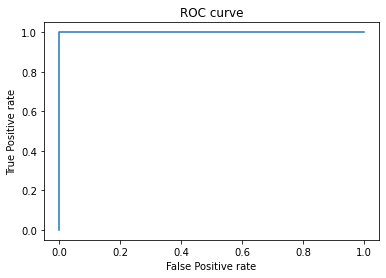

In [43]:
plt.plot(fpr[:20],tpr[:20])
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC curve")
plt.show()

## WBC  dataset

In [48]:
df = pd.read_csv('breast-cancer-wisconsin.csv', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [49]:
df.replace('?', np.nan, inplace = True)

In [50]:
df.isna().sum()

0     0
1     0
2     0
3     0
4     0
5    16
6     0
7     0
8     0
9     0
dtype: int64

In [51]:
df = df.astype(float)

In [52]:
df[5].mean()

3.5446559297218156

In [53]:
df = df.fillna(df.mean())

In [54]:
df.dtypes

0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
7    float64
8    float64
9    float64
dtype: object

In [55]:
df[5].unique()

array([ 1.        , 10.        ,  2.        ,  4.        ,  3.        ,
        9.        ,  7.        ,  3.54465593,  5.        ,  8.        ,
        6.        ])

In [174]:
iter = [0 for i in range(20)]
tpr = [0 for i in range(20)]
fpr = [0 for i in range(20)]
for i,alpha in enumerate(np.linspace(0,1,20)):
    A_nochange,_,_ = no_change_cal(df,2,alpha,50)
    A_change,_,_ = change_cal(df,2,alpha,50)
    A_criterion = A_nochange + A_change
    actual = [0 for i in range(50)] + [1 for i in range(50)]
    tn, fp, fn, tp = confusion_matrix(actual,A_criterion).ravel()
    tpr[i] = tp/(tp+fn)
    fpr[i] = fp/(fp+tn)

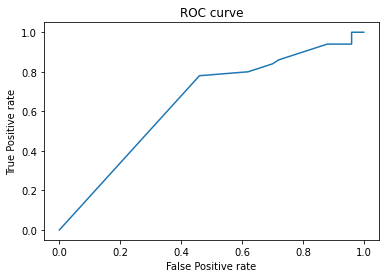

In [176]:
plt.plot(fpr,tpr)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC curve")
plt.show()

## Satimage dataset

In [123]:
df = pd.read_csv('satimage_csv.csv')
df.head()

,Aattr,Battr,Cattr,Dattr,Eattr,Fattr,A1attr,B2attr,C3attr,D4attr,...,D22attr,E23attr,F24attr,A25attr,B26attr,C27attr,D28attr,E29attr,F30attr,class
0,0.117596,1.241362,1.184036,0.815302,-0.158561,1.256483,1.193546,0.818486,-0.141965,0.879481,...,0.807707,-0.069968,1.219160,1.250463,0.597678,-0.054291,1.233342,1.262255,0.603258,1
1,-1.205362,-1.249654,-0.077532,0.444886,-0.895959,-0.447579,-0.786760,-0.554203,-0.364672,0.092157,...,-0.192752,-0.736996,-0.969292,-0.844805,-0.400030,-0.725852,-0.344432,-0.594534,-0.183967,5
2,0.779075,0.148811,0.042617,-0.243030,0.800057,0.164136,0.053370,-0.448612,0.154978,-0.345245,...,-0.877277,0.671174,-0.006373,-0.425752,-0.662584,0.691889,0.356801,-0.175259,-0.236449,7
3,1.146564,0.585831,0.342991,0.021553,0.947536,0.601074,0.353416,0.026550,1.788164,1.010702,...,0.281150,1.412317,1.044084,0.532085,0.282612,1.438068,1.058033,0.842981,0.130923,3
4,-0.764376,-1.162250,-0.137607,0.180303,-0.969698,-1.146681,-0.126658,0.184937,-0.735851,-1.132569,...,-0.192752,-0.885225,-1.231906,-0.784941,-0.347519,-0.875088,-1.220973,-0.774223,-0.551339,5


In [134]:
iter = [0 for i in range(20)]
tpr = [0 for i in range(20)]
fpr = [0 for i in range(20)]
for i,alpha in enumerate(np.linspace(0,1,20)):
    A_nochange,_,_ = no_change_cal(df,2,alpha,50)
    A_change,_,_ = change_cal(df,2,alpha,50)
    A_criterion = A_nochange + A_change
    actual = [0 for i in range(50)] + [1 for i in range(50)]
    tn, fp, fn, tp = confusion_matrix(actual,A_criterion).ravel()
    tpr[i] = tp/(tp+fn)
    fpr[i] = fp/(fp+tn)

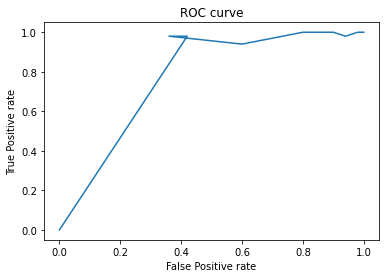

In [135]:
plt.plot(fpr,tpr)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC curve")
plt.show()

# For K = 3

## Shuttle dataset

In [177]:
df = pd.read_csv('shuttle.csv', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,55,0,81,0,-6,11,25,88,64,4
1,56,0,96,0,52,-4,40,44,4,4
2,50,-1,89,-7,50,0,39,40,2,1
3,53,9,79,0,42,-2,25,37,12,4
4,55,2,82,0,54,-6,26,28,2,1


In [180]:
iter = [0 for i in range(20)]
tpr = [0 for i in range(20)]
fpr = [0 for i in range(20)]
for i,alpha in enumerate(np.linspace(0,1,20)):
    A_nochange,_,_ = no_change_cal(df,3,alpha,50)
    A_change,_,_ = change_cal(df,3,alpha,50)
    A_criterion = A_nochange + A_change
    actual = [0 for i in range(50)] + [1 for i in range(50)]
    tn, fp, fn, tp = confusion_matrix(actual,A_criterion).ravel()
    tpr[i] = tp/(tp+fn)
    fpr[i] = fp/(fp+tn)

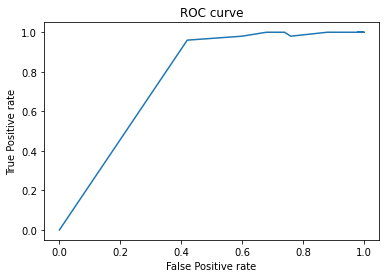

In [182]:
plt.plot(fpr,tpr)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC curve")
plt.show()

## WBC  dataset

In [183]:
df = pd.read_csv('breast-cancer-wisconsin.csv', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [184]:
df.replace('?', np.nan, inplace = True)

In [185]:
df.isna().sum()

0     0
1     0
2     0
3     0
4     0
5    16
6     0
7     0
8     0
9     0
dtype: int64

In [186]:
df = df.astype(float)

In [187]:
df[5].mean()

3.5446559297218156

In [188]:
df = df.fillna(df.mean())

In [189]:
df.dtypes

0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
7    float64
8    float64
9    float64
dtype: object

In [190]:
df[5].unique()

array([ 1.        , 10.        ,  2.        ,  4.        ,  3.        ,
        9.        ,  7.        ,  3.54465593,  5.        ,  8.        ,
        6.        ])

In [191]:
iter = [0 for i in range(20)]
tpr = [0 for i in range(20)]
fpr = [0 for i in range(20)]
for i,alpha in enumerate(np.linspace(0,1,20)):
    A_nochange,_,_ = no_change_cal(df,3,alpha,50)
    A_change,_,_ = change_cal(df,3,alpha,50)
    A_criterion = A_nochange + A_change
    actual = [0 for i in range(50)] + [1 for i in range(50)]
    tn, fp, fn, tp = confusion_matrix(actual,A_criterion).ravel()
    tpr[i] = tp/(tp+fn)
    fpr[i] = fp/(fp+tn)

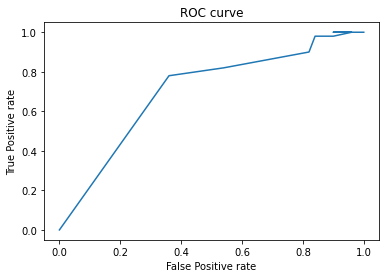

In [192]:
plt.plot(fpr,tpr)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC curve")
plt.show()

## Satimage dataset

In [193]:
df = pd.read_csv('satimage_csv.csv')
df.head()

,Aattr,Battr,Cattr,Dattr,Eattr,Fattr,A1attr,B2attr,C3attr,D4attr,...,D22attr,E23attr,F24attr,A25attr,B26attr,C27attr,D28attr,E29attr,F30attr,class
0,0.117596,1.241362,1.184036,0.815302,-0.158561,1.256483,1.193546,0.818486,-0.141965,0.879481,...,0.807707,-0.069968,1.219160,1.250463,0.597678,-0.054291,1.233342,1.262255,0.603258,1
1,-1.205362,-1.249654,-0.077532,0.444886,-0.895959,-0.447579,-0.786760,-0.554203,-0.364672,0.092157,...,-0.192752,-0.736996,-0.969292,-0.844805,-0.400030,-0.725852,-0.344432,-0.594534,-0.183967,5
2,0.779075,0.148811,0.042617,-0.243030,0.800057,0.164136,0.053370,-0.448612,0.154978,-0.345245,...,-0.877277,0.671174,-0.006373,-0.425752,-0.662584,0.691889,0.356801,-0.175259,-0.236449,7
3,1.146564,0.585831,0.342991,0.021553,0.947536,0.601074,0.353416,0.026550,1.788164,1.010702,...,0.281150,1.412317,1.044084,0.532085,0.282612,1.438068,1.058033,0.842981,0.130923,3
4,-0.764376,-1.162250,-0.137607,0.180303,-0.969698,-1.146681,-0.126658,0.184937,-0.735851,-1.132569,...,-0.192752,-0.885225,-1.231906,-0.784941,-0.347519,-0.875088,-1.220973,-0.774223,-0.551339,5


In [196]:
tpr = [0 for i in range(20)]
fpr = [0 for i in range(20)]
for i,alpha in enumerate(np.linspace(0,1,20)):
    A_nochange,_,_ = no_change_cal(df,3,alpha,50)
    A_change,_,_ = change_cal(df,3,alpha,50)
    A_criterion = A_nochange + A_change
    actual = [0 for i in range(50)] + [1 for i in range(50)]
    tn, fp, fn, tp = confusion_matrix(actual,A_criterion).ravel()
    tpr[i] = tp/(tp+fn)
    fpr[i] = fp/(fp+tn)

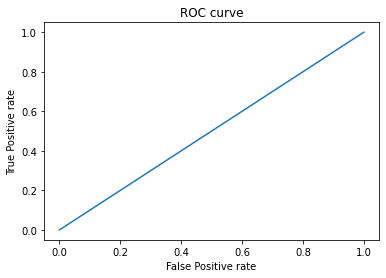

In [197]:
plt.plot(fpr,tpr)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC curve")
plt.show()